In [1]:
import numpy as np 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from glob import glob

from importlib import reload
from scipy.stats import pearsonr
import seaborn as sns 
import numpy.linalg as npl 

import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
base='/mnt/home/awakhloo/ceph/population_geometry_opt_coding'
codedir = base+'/code'
import sys 
sys.path.append(codedir)
import rat_utils as rat

outdir = base+'/results'
figdir = base+'/figures/pngs'

In [2]:
dt=0.5
arrpf = np.load(outdir + f'/PFC_results_nu_dt_{dt}_ns_500_P_300.npy',
                allow_pickle=True).item() 
errs_pfc, all_geoms_pfc = arrpf['errs'], arrpf['all_geoms']
arrca1 = np.load(outdir + f'/CA1_results_nu_dt_{dt}_ns_500_P_300.npy',
                allow_pickle=True).item() 
errs_ca1, all_geoms_ca1 = arrca1['errs'], arrca1['all_geoms']

n_subset=500
subset_neur_pfc=19
# paths_pfc_glms = glob(outdir + '/glm_results/glm_res_PFC_bin*.npy')
# params_pfc, scores_pfc = rat.find_best_params(paths_pfc_glms, subset_neur_pfc) 
# print("best pfc GLM params = ", params_pfc[np.argmax(scores_pfc)])
all_res = np.load(outdir + '/glm_results/glm_res_PFC_bin_size_10_bin_size_vel_3_sp_100_sv_40.npy',
              allow_pickle=True).item()['results']
dims_pfc, _, test_scores_pfc, test_devs_pfc, *_ = rat.format_glm_results(all_res,n_subset=n_subset,
                                            subset_neur=subset_neur_pfc)



subset_neur_ca1=19
# paths_ca1_glms = glob(outdir + '/glm_results/glm_res_CA1_bin*.npy')
# params_ca1, scores_ca1 = rat.find_best_params(paths_ca1_glms, subset_neur_ca1) 
# print("best CA1 GLM params = ", params_ca1[np.argmax(scores_ca1)])


all_res = np.load(outdir+'/glm_results/glm_res_CA1_bin_size_10_bin_size_vel_3_sp_100_sv_40.npy',
              allow_pickle=True).item()['results']
dims_ca1, _, test_scores_ca1, test_devs_ca1, *_ = rat.format_glm_results(all_res,n_subset=n_subset,
                                                          subset_neur=subset_neur_ca1)

rat 0
rat 1
rat 2
rat 3
rat 4
rat 5
rat 6
rat 7
rat 0
rat 1
rat 2
rat 3
rat 4
rat 5
rat 6
rat 7


In [3]:
def plot_CI(dat, color, ax,ls):
    ''' format data to work with seaborn lineplot. 
    assumes samples are on leading axis, and indices are on trailing axis'''
    dat = pd.DataFrame(dat).melt()
    dat['variable']+=1
    sns.lineplot(x='variable',y='value',
                 data=dat,
                # errorbar='ci',
                 errorbar=('se',1),
                color=color,
                 ls=ls,
                ax=ax)
    ax.set_ylabel("")

def plot_geom(a, G, sesh, ls, fn, lab,col,lwm): 
    a.plot(sesh, G.mean(0), color=col, lw=lwm, ls=ls) 
    plot_CI(G, color=col, ax=a, ls=ls)
    a.set_xlabel("session", fontsize=fn) 
    a.set_title(lab, fontsize=fn)

def plot_rat_results_joint_together(errs_pfc, all_geoms_pfc,
                     errs_ca1, all_geoms_ca1,
                    dims_ca1,dims_pfc,
                     col_pfc, col_ca1,
                     S=8, lw=1, lwm=4, fn=14, ms=15, msm=20,
                     alpha=0.5, nrat=8, fsize=(12,7)):
    ''' 
    errs are arrays of shape: (num subset, num rat, num sesh, err types) with the last axis being like (behavior, empirical, theory, svm)
    geoms have the same shape with the last axis like: (dim, corr, snf, ssf)
    '''
    fig, ax = plt.subplots(2,4, figsize=fsize)
    sesh = np.arange(1,S+1)
    nrat = errs_pfc.shape[1] 
    
    cs = ['grey' for _ in range(8)]
    cs_two = ['midnightblue', 'salmon', 'olive', 'purple', 'orange', 'olive', 'green', 'purple']
    geom_names = ['total dimension', 
                  'neural-latent correlation', 
                  'signal-noise factorization', 
                  'signal-signal factorization',
                  'dimension of \n task-related variability']

    # behavior
    ax[0,0].plot(sesh, 1-errs_pfc.mean((0,1))[:S,0], color='k',
                 lw=lwm,
                markersize=msm)
    plot_CI(1-errs_pfc.mean(0)[:,:S,0],
            color='k',
            ax=ax[0,0],ls='-')
    
    for errs, all_geoms, col, label, dims in zip(
        [errs_ca1, errs_pfc], [all_geoms_ca1, all_geoms_pfc],
        [col_ca1, col_pfc], ['CA1', 'PFC'], [dims_ca1,dims_pfc]):
        ls = '-' if label == 'PFC' else '--'
        # [errs_pfc, errs_ca1], [all_geoms_pfc, all_geoms_ca1], [col_pfc, col_ca1], ['PFC', 'CA1']): 
        # theory vs. emp 
        ax[0,2].scatter(errs.mean(0)[:, :S, 1].reshape(-1),
                     errs.mean(0)[:, :S, 2].reshape(-1),
                     color=col,
                        s=ms,
                     label=label,
                       alpha=0.5) 
        XX = np.linspace(0.25,0.38,100) 
        ax[0,2].plot(XX,XX,lw=lwm, ls='--', color='grey')
        # readout vs. sesh 
        ax[0,1].plot(sesh, errs.mean((0,1))[:S,2], 
                     color=col, 
                     lw=lwm,
                    markersize=msm,
                    label=label,
                    ls=ls)
        plot_CI(errs.mean(0)[:,:S,2],
                color=col, 
                ax=ax[0,1], ls=ls)
        # # theory vs behavior
        # sns.regplot(x=1-errs.mean(0)[:,:S,0].flatten(), # behv. 
        #             y=errs.mean(0)[:,:S,2].flatten(), # the.
        #             color=col,
        #             scatter=True,
        #             scatter_kws={'s' : ms, 'alpha' : 0.5},
        #             line_kws={'lw':lwm, 'ls' : ls},
        #            ax=ax[0,2])
        r2 = pearsonr(1-errs.mean(0)[:,:S,0].flatten(),
                            errs.mean(0)[:,:S,2].flatten())[0]**2
        print(f"{label} r2 = ", r2, " r = ", np.sqrt(r2))
        # ax[0,1].text(0.525,0.3 if label == 'CA1' else 0.29, 
        #              f'r$^2$ ({label}) = ' + str(round(r2,2)),
        #             color = col)    


        plot_geom(a=ax[0,-1],
                  G=all_geoms.mean(0)[:,:S,0],
                  sesh=sesh,
                  lab="total dimension",
                  ls=ls,
                  col=col, 
                  fn=fn, lwm=lwm)
        plot_geom(a=ax[1,0],
                  G=dims[:,:S,1],
                  sesh=sesh,
                  lab="dim. task-relevant variability",
                  ls=ls,
                  col=col, 
                  fn=fn, lwm=lwm)
        plot_geom(a=ax[1,1],
                  G=all_geoms.mean(0)[:,:S,3],
                  sesh=sesh,
                  lab=geom_names[3],
                  ls=ls,
                  col=col, 
                  fn=fn, lwm=lwm)
        plot_geom(a=ax[1,2],
                  G=all_geoms.mean(0)[:,:S,1],
                  sesh=sesh,
                  lab=geom_names[1],
                  ls=ls,
                  col=col, 
                  fn=fn, lwm=lwm)
        plot_geom(a=ax[1,3],
                  G=all_geoms.mean(0)[:,:S,2],
                  sesh=sesh,
                  lab=geom_names[2],
                  ls=ls,
                  col=col, 
                  fn=fn, lwm=lwm)
        
        
        
        
    
    
    for i, a in enumerate(ax.flat): 
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
    
    ax[0,0].set_title('alternation task error', fontsize=fn) 
    ax[0,1].set_title(r'readout error ($E_g$)', fontsize=fn)
    # ax[0,2].set_title("readout vs. alternation task error", fontsize=fn)
    ax[0,2].set_title("theory vs. empirical $E_g$", fontsize=fn) 
    
    ax[0,0].set_xlabel("session", fontsize=fn) 
    ax[0,1].set_xlabel("session", fontsize=fn) 
    # ax[0,2].set_xlabel("alternation task error", fontsize=fn) 
    ax[0,2].set_xlabel("empirical readout error", fontsize=fn)
    ax[0,3].set_xlabel("session", fontsize=fn)

    ax[0,0].set_ylabel("alternation task error", fontsize=fn) 
    ax[0,1].set_ylabel("theoretical readout error", fontsize=fn)
    # ax[0,2].set_ylabel("theoretical readout error", fontsize=fn) 
    ax[0,2].set_ylabel("theoretical readout error", fontsize=fn)
    ax[0,3].set_ylabel(" ", fontsize=fn)
    
    
    plt.tight_layout(h_pad=2.5,w_pad=3)
    return fig,ax

CA1 r2 =  0.4790656467403378  r =  0.6921456831768423
PFC r2 =  0.5065475993261047  r =  0.7117215743014291


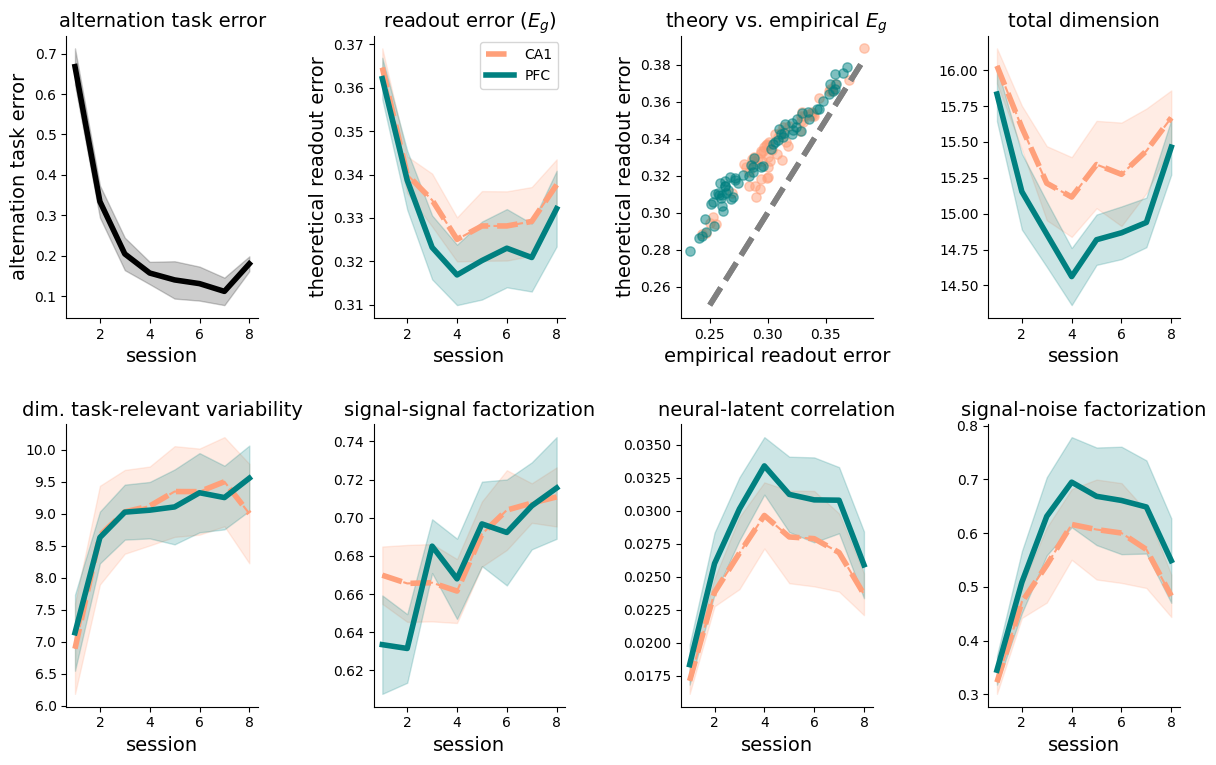

In [4]:
fsize=(12,7.75)
fig,ax = plot_rat_results_joint_together(errs_pfc, all_geoms_pfc, 
                          errs_ca1, all_geoms_ca1,
                                         dims_ca1,dims_pfc ,
                          fn=14,
                          S=8, 
                          ms=45,
                          alpha=0.,
                          col_pfc='teal',
                          # col_ca1='tomato',
                                col_ca1='lightsalmon',
                                         fsize=fsize,
                         )
fig.savefig(figdir+'/joint_results.pdf',
            dpi=300,bbox_inches='tight') 

In [5]:
def fit_lin(g): 
    ''' g: an array of shape (n rats,  n sesh) with the desired variable'''
    nr, ns = g.shape
    time = np.tile(np.arange(1,ns+1), nr) # repeats (1,2,3...., 123,....) 
    X = sm.add_constant(time) 
    print(X.shape)
    gflat = g.reshape(-1) # rat_1 t_1, ..., rat_1 t_ns, ...., rat_2 t_1, ..., rat_2 t_ns, ... 
    model = sm.OLS(gflat, X)
    result = model.fit()
    print(result.summary())
    

def fit_quad_mixed(g) :
    n_subjects, n_timepoints = g.shape
    # put data into long form 
    time = np.tile(np.arange(n_timepoints), n_subjects)
    subject = np.repeat(np.arange(n_subjects), n_timepoints)
    y_values = g.reshape(-1)
    
    df = pd.DataFrame({
        'Y': y_values,
        'time': time,
        'subject': subject.astype(str)  # string for categorical subject IDs
    })
    
    df['time_squared'] = df['time'] ** 2
    
    model = smf.mixedlm("Y ~ time + time_squared", df, groups=df["subject"]) # mixed effects
    # model = smf.ols("Y ~ time + time_squared", df) # fixed effects
    result = model.fit()
    print(result.summary())
    print(result.pvalues)

    # get the estimated geometry over time 
    mean_y_by_time = df.groupby('time')['Y'].mean()
    # params from model; note these are the fixed effects. random effect intercepts are also fit. 
    intercept = result.params['Intercept']
    slope = result.params['time']
    quad = result.params['time_squared']
    pvals = result.pvalues 
    
    # Generate smooth fitted curve
    time_vals = np.arange(n_timepoints)
    fitted_vals = intercept + slope * time_vals + quad * time_vals**2
    
    # ---- Optional: Plot individual subject trajectories ----
    plt.figure(figsize=(3,5))
    
    for subj in df['subject'].unique():
        subj_data = df[df['subject'] == subj]
        plt.plot(subj_data['time'], subj_data['Y'], color='gray', alpha=0.3)
    
    # ---- Plot mean data and fitted curve ----
    plt.plot(time_vals, mean_y_by_time, 'o-', label='Mean observed Y', color='blue')
    plt.plot(time_vals, fitted_vals, 'r--', label='Quadratic fit (fixed effects)', linewidth=2)
    
    plt.xlabel("Time")
    plt.ylabel("Y")
    plt.title("Quadratic Mixed-Effects Model Fit")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return time_vals, fitted_vals, np.array([pvals['time'], pvals['time_squared']]), np.array([slope, quad]) 


def fit_lin_mixed(g) :
    n_subjects, n_timepoints = g.shape
    # put data into long form 
    time = np.tile(np.arange(n_timepoints), n_subjects)
    subject = np.repeat(np.arange(n_subjects), n_timepoints)
    y_values = g.reshape(-1)
    
    df = pd.DataFrame({
        'Y': y_values,
        'time': time,
        'subject': subject.astype(str)  # string for categorical subject IDs
    })    
    model = smf.mixedlm("Y ~ time", df, groups=df["subject"]) # mixed effects
    result = model.fit()
    print(result.summary())
    print(result.pvalues)

    # get the estimated geometry over time 
    mean_y_by_time = df.groupby('time')['Y'].mean()
    # params from model; note these are the fixed effects. random effect intercepts are also fit. 
    intercept = result.params['Intercept']
    slope = result.params['time']
    pvals = result.pvalues 
    
    # Generate smooth fitted curve
    time_vals = np.arange(n_timepoints)
    fitted_vals = intercept + slope * time_vals 
    
    # ---- Optional: Plot individual subject trajectories ----
    plt.figure(figsize=(3,5))
    
    for subj in df['subject'].unique():
        subj_data = df[df['subject'] == subj]
        plt.plot(subj_data['time'], subj_data['Y'], color='gray', alpha=0.3)
    
    # ---- Plot mean data and fitted curve ----
    plt.plot(time_vals, mean_y_by_time, 'o-', label='Mean observed Y', color='blue')
    plt.plot(time_vals, fitted_vals, 'r--', label='Linear fit (fixed effects)', linewidth=2)
    
    plt.xlabel("Time")
    plt.ylabel("Y")
    plt.title("Linear Mixed-Effects Model Fit")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return time_vals, fitted_vals, pvals['time'], slope



On dim. for area PFC
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Y       
No. Observations:  64      Method:             REML    
No. Groups:        8       Scale:              0.1480  
Min. group size:   8       Log-Likelihood:     -45.1483
Max. group size:   8       Converged:          Yes     
Mean group size:   8.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    15.749    0.188 83.700 0.000 15.380 16.117
time         -0.586    0.076 -7.672 0.000 -0.736 -0.436
time_squared  0.078    0.010  7.432 0.000  0.057  0.099
Group Var     0.178    0.291                           

Intercept       0.000000e+00
time            1.688115e-14
time_squared    1.068204e-13
Group Var       1.107449e-01
dtype: float64


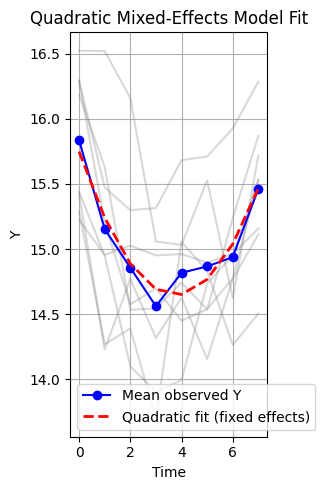



On corr. for area PFC
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Y       
No. Observations:  64      Method:             REML    
No. Groups:        8       Scale:              0.0000  
Min. group size:   8       Log-Likelihood:     232.3009
Max. group size:   8       Converged:          Yes     
Mean group size:   8.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.019    0.002  8.147 0.000  0.015  0.024
time          0.007    0.001  8.600 0.000  0.005  0.008
time_squared -0.001    0.000 -7.729 0.000 -0.001 -0.001
Group Var     0.000    0.005                           

Intercept       3.726557e-16
time            7.977828e-18
time_squared    1.083622e-14
Group Var       9.592603e-02
dtype: float64


/mnt/home/awakhloo/miniforge3/envs/reprod_abstr/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


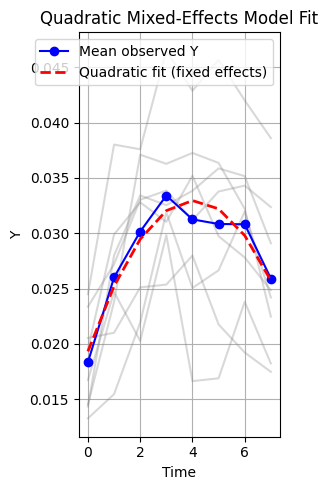



On snf for area PFC
         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Y      
No. Observations:   64      Method:             REML   
No. Groups:         8       Scale:              0.0116 
Min. group size:    8       Log-Likelihood:     29.3624
Max. group size:    8       Converged:          Yes    
Mean group size:    8.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.361    0.074  4.847 0.000  0.215  0.506
time          0.163    0.021  7.600 0.000  0.121  0.205
time_squared -0.020    0.003 -6.637 0.000 -0.025 -0.014
Group Var     0.036    0.198                           

Intercept       1.255187e-06
time            2.963232e-14
time_squared    3.191010e-11
Group Var       9.061930e-02
dtype: float64


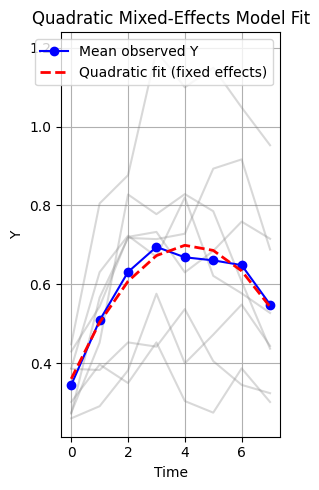



On ssf for area PFC
         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Y      
No. Observations:   64      Method:             REML   
No. Groups:         8       Scale:              0.0021 
Min. group size:    8       Log-Likelihood:     84.9045
Max. group size:    8       Converged:          Yes    
Mean group size:    8.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.630    0.021 30.390 0.000  0.589  0.670
time          0.019    0.009  2.082 0.037  0.001  0.037
time_squared -0.001    0.001 -0.822 0.411 -0.004  0.001
Group Var     0.002    0.027                           

Intercept       7.392102e-203
time             3.732187e-02
time_squared     4.110084e-01
Group Var        1.226163e-01
dtype: float64


/mnt/home/awakhloo/miniforge3/envs/reprod_abstr/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


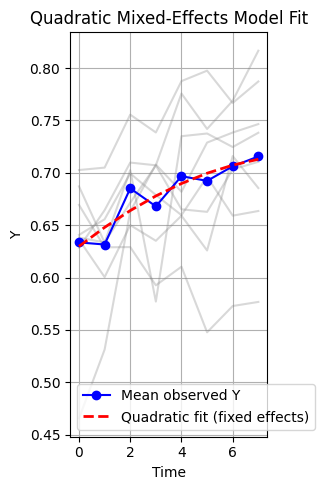



        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y      
No. Observations: 64      Method:             REML   
No. Groups:       8       Scale:              0.0021 
Min. group size:  8       Log-Likelihood:     90.3217
Max. group size:  8       Converged:          Yes    
Mean group size:  8.0                                
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.637    0.019 34.017 0.000  0.600  0.674
time        0.012    0.003  4.716 0.000  0.007  0.017
Group Var   0.002    0.027                           

Intercept    1.255086e-253
time          2.406323e-06
Group Var     1.219176e-01
dtype: float64


/mnt/home/awakhloo/miniforge3/envs/reprod_abstr/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


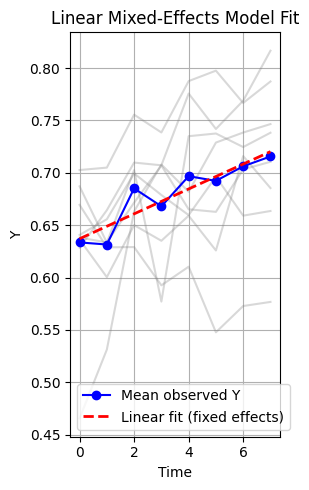

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Y       
No. Observations:  64      Method:             REML    
No. Groups:        8       Scale:              0.6313  
Min. group size:   8       Log-Likelihood:     -91.6602
Max. group size:   8       Converged:          Yes     
Mean group size:   8.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     7.550    0.497 15.203 0.000  6.577  8.524
time          0.712    0.158  4.514 0.000  0.403  1.022
time_squared -0.066    0.022 -3.050 0.002 -0.109 -0.024
Group Var     1.526    1.148                           

Intercept       3.399174e-52
time            6.348583e-06
time_squared    2.286096e-03
Group Var       9.419555e-02
dtype: float64


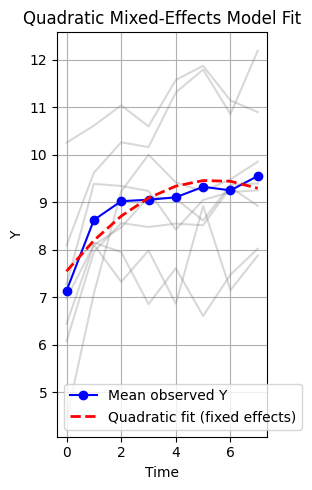

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y       
No. Observations: 64      Method:             REML    
No. Groups:       8       Scale:              0.7266  
Min. group size:  8       Log-Likelihood:     -93.1146
Max. group size:  8       Converged:          Yes     
Mean group size:  8.0                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    8.013    0.477 16.815 0.000  7.079  8.947
time         0.250    0.047  5.366 0.000  0.158  0.341
Group Var    1.514    1.068                           

Intercept    1.906204e-63
time         8.056990e-08
Group Var    9.642579e-02
dtype: float64


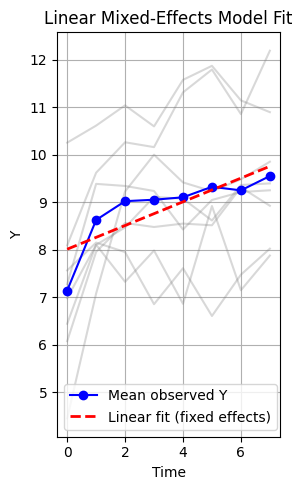

On dim. for area CA1
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Y       
No. Observations:  64      Method:             REML    
No. Groups:        8       Scale:              0.1530  
Min. group size:   8       Log-Likelihood:     -48.4320
Max. group size:   8       Converged:          Yes     
Mean group size:   8.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    15.965    0.245 65.274 0.000 15.485 16.444
time         -0.417    0.078 -5.372 0.000 -0.570 -0.265
time_squared  0.055    0.011  5.120 0.000  0.034  0.076
Group Var     0.370    0.565                           

Intercept       0.000000e+00
time            7.778250e-08
time_squared    3.049519e-07
Group Var       9.417890e-02
dtype: float64


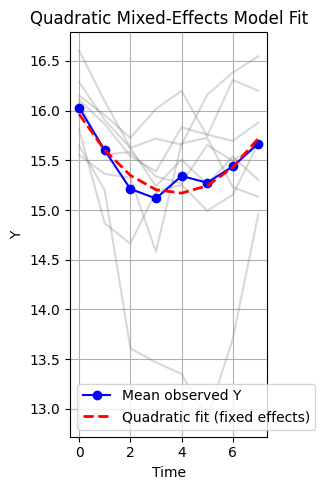



On corr. for area CA1
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Y       
No. Observations:  64      Method:             REML    
No. Groups:        8       Scale:              0.0000  
Min. group size:   8       Log-Likelihood:     219.6000
Max. group size:   8       Converged:          Yes     
Mean group size:   8.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.018    0.002  7.726 0.000  0.013  0.023
time          0.006    0.001  5.557 0.000  0.004  0.008
time_squared -0.001    0.000 -5.008 0.000 -0.001 -0.000
Group Var     0.000    0.003                           

Intercept       1.109885e-14
time            2.745154e-08
time_squared    5.505510e-07
Group Var       1.181184e-01
dtype: float64


/mnt/home/awakhloo/miniforge3/envs/reprod_abstr/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


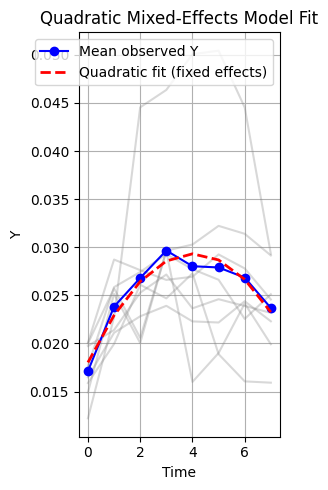



On snf for area CA1
         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Y      
No. Observations:   64      Method:             REML   
No. Groups:         8       Scale:              0.0160 
Min. group size:    8       Log-Likelihood:     23.0861
Max. group size:    8       Converged:          Yes    
Mean group size:    8.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.333    0.060  5.580 0.000  0.216  0.450
time          0.140    0.025  5.581 0.000  0.091  0.189
time_squared -0.017    0.003 -4.926 0.000 -0.024 -0.010
Group Var     0.017    0.086                           

Intercept       2.404511e-08
time            2.389313e-08
time_squared    8.413931e-07
Group Var       1.146830e-01
dtype: float64


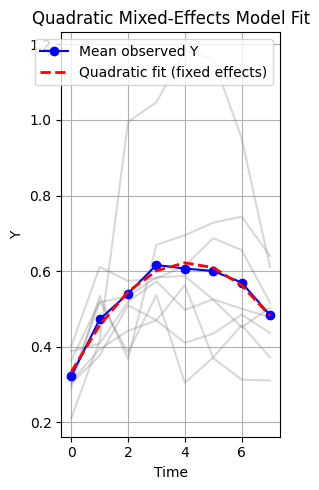



On ssf for area CA1
        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Y      
No. Observations:  64      Method:             REML   
No. Groups:        8       Scale:              0.0016 
Min. group size:   8       Log-Likelihood:     95.4729
Max. group size:   8       Converged:          Yes    
Mean group size:   8.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.665    0.015 43.758 0.000  0.635  0.695
time         0.001    0.008  0.102 0.919 -0.015  0.017
time_squared 0.001    0.001  0.885 0.376 -0.001  0.003
Group Var    0.001    0.013                           

Intercept       0.000000
time            0.918505
time_squared    0.376330
Group Var       0.173797
dtype: float64


/mnt/home/awakhloo/miniforge3/envs/reprod_abstr/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


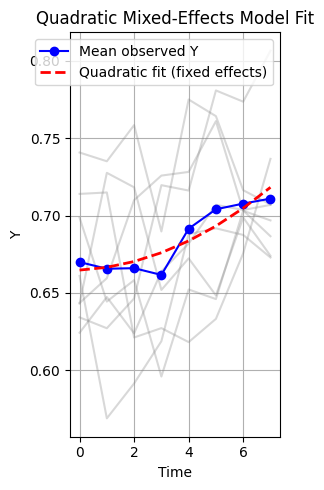



        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y       
No. Observations: 64      Method:             REML    
No. Groups:       8       Scale:              0.0016  
Min. group size:  8       Log-Likelihood:     100.9744
Max. group size:  8       Converged:          Yes     
Mean group size:  8.0                                 
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.658    0.013 50.290 0.000  0.632  0.684
time         0.008    0.002  3.476 0.001  0.003  0.012
Group Var    0.001    0.013                           

Intercept    0.000000
time         0.000510
Group Var    0.172847
dtype: float64


/mnt/home/awakhloo/miniforge3/envs/reprod_abstr/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


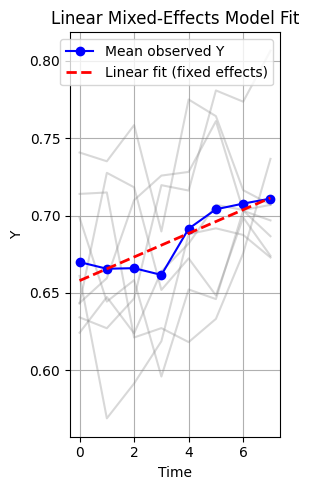

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Y       
No. Observations:  64      Method:             REML    
No. Groups:        8       Scale:              0.6057  
Min. group size:   8       Log-Likelihood:     -93.2035
Max. group size:   8       Converged:          Yes     
Mean group size:   8.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     7.274    0.688 10.572 0.000  5.925  8.622
time          0.990    0.155  6.408 0.000  0.687  1.293
time_squared -0.107    0.021 -5.053 0.000 -0.149 -0.066
Group Var     3.358    2.506                           

Intercept       4.022917e-26
time            1.479173e-10
time_squared    4.352882e-07
Group Var       8.516497e-02
dtype: float64


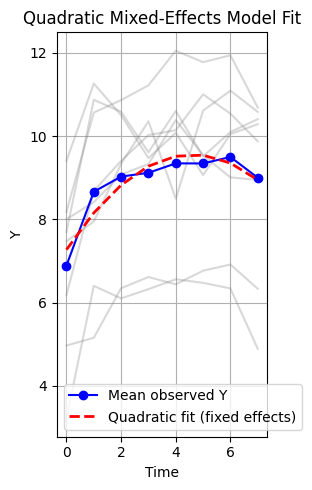

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y        
No. Observations: 64      Method:             REML     
No. Groups:       8       Scale:              0.8759   
Min. group size:  8       Log-Likelihood:     -100.9125
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     8.025    0.679 11.818 0.000  6.694  9.355
time          0.239    0.051  4.689 0.000  0.139  0.339
Group Var     3.324    2.082                           

Intercept    3.167106e-32
time         2.743869e-06
Group Var    8.798195e-02
dtype: float64


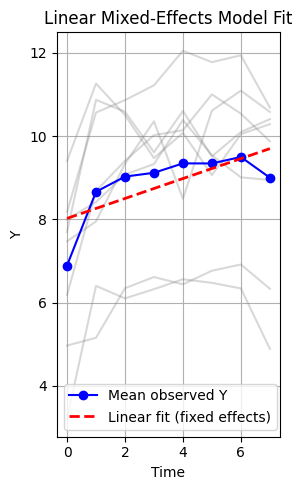

In [6]:
# recall geom has shape (subset, rat, sesh, (dim, corr, snf, ssf))
# div = 4 # divider btw early vs. late 
Gs = [all_geoms_pfc, all_geoms_ca1]
dims = [dims_pfc, dims_ca1]
labs = ['PFC', 'CA1'] 
labs_g = ['dim.', 'corr.', 'snf', 'ssf'] 
exclude_ca1_outlier = False 
dfs = [] 
fits = {} 
for i, G in enumerate(Gs): 
    fits[labs[i]] = {} 
    # geometry
    for j, lg in enumerate(labs_g): 
        if i == 1 and exclude_ca1_outlier is True: 
            G = np.concatenate([G[:, :5], G[:, 6:]],axis=1)
        print(f"On {lg} for area {labs[i]}")
        g = G.mean(0)[..., j] # rat x session
        T, model_fit, pvals, params = fit_quad_mixed(g)
        results = pd.DataFrame({
                    'Area' : labs[i], 
                    'model' : 'Quad.',
                   'meas' : lg, 
                   'plin' : pvals[0], 
                   'pquad' : pvals[1], 
                   'blin' : params[0], 
                   'bquad' : params[1]}, index=[0])
        dfs.append(results)
        fits[labs[i]][lg] = model_fit
        print('\n')
    # fit the linear model for SSF 
    assert lg == 'ssf', "ensure only linear modeling is SSF" 
    T, model_fit_lin, pval_lin, param_lin = fit_lin_mixed(g)
    results = pd.DataFrame({'Area' : labs[i],
                            'model' : 'Linear', 
                            'meas' : lg, 
                            'plin' : pval_lin, 
                            'pquad' : np.nan, 
                            'blin' : param_lin,
                            'bquad' : np.nan},index=[0])
    dfs.append(results) 
    # task dimensions 
    # quad
    g = dims[i][...,1]
    T, model_fit_quad, pval_quad, param_quad = fit_quad_mixed(g)
    results = pd.DataFrame({'Area' : labs[i],
                            'model' : 'Quad.', 
                            'meas' : 'task dim.', 
                            'plin' : pval_quad[0], 
                            'pquad' : pval_quad[1], 
                            'blin' : param_quad[0],
                            'bquad' : param_quad[1]},index=[0])
    dfs.append(results) 
    fits[labs[i]]['task_dim'] = model_fit_quad
    # linear 
    T, model_fit_lin, pval_lin, param_lin = fit_lin_mixed(g)
    results = pd.DataFrame({'Area' : labs[i],
                            'model' : 'Linear', 
                            'meas' : 'task dim.', 
                            'plin' : pval_lin, 
                            'pquad' : np.nan, 
                            'blin' : param_lin,
                            'bquad' : np.nan},index=[0])
    dfs.append(results) 
    
    
    

    
res_df = pd.concat(dfs, ignore_index=True)
res_df = res_df.sort_values('bquad')

In [7]:
res_df

,Area,model,meas,plin,pquad,blin,bquad
12,CA1,Quad.,task dim.,1.479173e-10,4.352882e-07,0.990271,-0.107266
5,PFC,Quad.,task dim.,6.348583e-06,2.286096e-03,0.712303,-0.066110
2,PFC,Quad.,snf,2.963232e-14,3.191010e-11,0.162657,-0.019513
9,CA1,Quad.,snf,2.389313e-08,8.413931e-07,0.140111,-0.016985
3,PFC,Quad.,ssf,3.732187e-02,4.110084e-01,0.019158,-0.001039
1,PFC,Quad.,corr.,7.977828e-18,1.083622e-14,0.006738,-0.000832
8,CA1,Quad.,corr.,2.745154e-08,5.505510e-07,0.005590,-0.000692
10,CA1,Quad.,ssf,9.185053e-01,3.763295e-01,0.000820,0.000974
7,CA1,Quad.,dim.,7.778250e-08,3.049519e-07,-0.417275,0.054630
0,PFC,Quad.,dim.,1.688115e-14,1.068204e-13,-0.586114,0.077988


In [8]:
# get the pvalues together and do multiple comparisons
pvals = np.concatenate([res_df.plin.values, res_df.dropna().pquad.values])
res, pcor, *_ = multipletests(pvals, alpha=0.01, method='fdr_bh')
res_df['p lin. adj.'] = pcor[:res_df.shape[0]]
# reinsert the nans for the quad slot where the linear term appears
quadp = np.zeros(len(res_df)) * np.nan
quadp[:-4] = pcor[res_df.shape[0]:]
res_df['p quad. adj.'] = quadp
# format data
res_df = res_df.sort_values('model', ascending=False)
ord = ['Area', 'model', 'meas', 'blin', 'plin', 'p lin. adj.',
       'bquad', 'pquad', 'p quad. adj.']
res_df = res_df[ord]

# # sanity checks : reject null
# res_df['r_eta'] = res_df['p quad. adj.'] < 0.01 
# res_df[r'_gam'] = res_df['p lin. adj.'] < 0.01

new_names = {'Area' : 'Area',
             'model' : 'Model',
             'meas' : 'Measure',
             'blin' :  r'$\gamma$',
             'plin' : r'$p_\gamma$',
             'p lin. adj.' : r'$p_\gamma$ (adj.)',
             'bquad' : r'$\eta$',
             'pquad' : r'$p_\eta$',
             'p quad. adj.' : r'$p_\eta$ (adj.)'}
res_df = res_df.rename(columns=new_names)
res_df

,Area,Model,Measure,$\gamma$,$p_\gamma$,$p_\gamma$ (adj.),$\eta$,$p_\eta$,$p_\eta$ (adj.)
12,CA1,Quad.,task dim.,0.990271,1.479173e-10,5.071451e-10,-0.107266,4.352882e-07,8.036090e-07
5,PFC,Quad.,task dim.,0.712303,6.348583e-06,8.464777e-06,-0.066110,2.286096e-03,2.743315e-03
2,PFC,Quad.,snf,0.162657,2.963232e-14,1.777939e-13,-0.019513,3.191010e-11,1.276404e-10
9,CA1,Quad.,snf,0.140111,2.389313e-08,7.167938e-08,-0.016985,8.413931e-07,1.346229e-06
3,PFC,Quad.,ssf,0.019158,3.732187e-02,4.265356e-02,-0.001039,4.110084e-01,4.288783e-01
1,PFC,Quad.,corr.,0.006738,7.977828e-18,1.914679e-16,-0.000832,1.083622e-14,1.300347e-13
8,CA1,Quad.,corr.,0.005590,2.745154e-08,7.320410e-08,-0.000692,5.505510e-07,9.438017e-07
10,CA1,Quad.,ssf,0.000820,9.185053e-01,9.185053e-01,0.000974,3.763295e-01,4.105413e-01
7,CA1,Quad.,dim.,-0.417275,7.778250e-08,1.757889e-07,0.054630,3.049519e-07,6.099038e-07
0,PFC,Quad.,dim.,-0.586114,1.688115e-14,1.350492e-13,0.077988,1.068204e-13,5.127379e-13


In [9]:
# # get the pvalues together and do multiple comparisons
# pvals = np.concatenate([res_df.plin.values, res_df.dropna().pquad.values])
# res, pcor, *_ = multipletests(pvals, alpha=0.01, method='bonferroni')
# res_df['p lin. adj.'] = pcor[:res_df.shape[0]]
# # reinsert the nans for the quad slot where the linear term appears
# quadp = np.zeros(len(res_df)) * np.nan
# quadp[:4] = pcor[res_df.shape[0]:res_df.shape[0]+4]
# quadp[-6:-2] = pcor[-4:]
# res_df['p quad. adj.'] = quadp
# # format data
# res_df = res_df.sort_values('model', ascending=False)
# ord = ['Area', 'model', 'meas', 'blin', 'plin', 'p lin. adj.',
#        'bquad', 'pquad', 'p quad. adj.']
# res_df = res_df[ord]

# # # sanity checks : reject null
# # res_df['r_eta'] = res_df['p quad. adj.'] < 0.01 
# # res_df[r'_gam'] = res_df['p lin. adj.'] < 0.01

# new_names = {'Area' : 'Area',
#              'model' : 'Model',
#              'meas' : 'Measure',
#              'blin' :  r'$\gamma$',
#              'plin' : r'$p_\gamma$',
#              'p lin. adj.' : r'$p_\gamma$ (adj.)',
#              'bquad' : r'$\eta$',
#              'pquad' : r'$p_\eta$',
#              'p quad. adj.' : r'$p_\eta$ (adj.)'}
# res_df = res_df.rename(columns=new_names)
# res_df

In [10]:
def format_dataframe(df, sig_digits=3, sci_thresh=1e-3, sci_digits=1):
    '''format the numerical columns of a df so that it shows up nicely in overleaf. '''
    def format_number(x):
        if pd.isna(x):
            return x
        if abs(x) < sci_thresh and x != 0:
            return f"{x:.{sci_digits}e}"
        else:
            # Round to significant digits
            return f"{x:.{sig_digits}g}"
    
    formatted_df = df.copy()
    for col in formatted_df.select_dtypes(include=[np.number]).columns:
        formatted_df[col] = formatted_df[col].apply(format_number)
    return formatted_df

out = format_dataframe(res_df)
out = out.sort_values("Area",ascending=False)
out.to_csv(outdir + '/rat_stats.csv',index=False)
out

,Area,Model,Measure,$\gamma$,$p_\gamma$,$p_\gamma$ (adj.),$\eta$,$p_\eta$,$p_\eta$ (adj.)
5,PFC,Quad.,task dim.,0.712,6.3e-06,8.5e-06,-0.0661,0.00229,0.00274
2,PFC,Quad.,snf,0.163,3.0e-14,1.8e-13,-0.0195,3.2e-11,1.3e-10
3,PFC,Quad.,ssf,0.0192,0.0373,0.0427,-0.00104,0.411,0.429
1,PFC,Quad.,corr.,0.00674,8.0e-18,1.9e-16,-8.3e-04,1.1e-14,1.3e-13
0,PFC,Quad.,dim.,-0.586,1.7e-14,1.4e-13,0.078,1.1e-13,5.1e-13
4,PFC,Linear,ssf,0.0119,2.4e-06,3.6e-06,NaN,NaN,NaN
6,PFC,Linear,task dim.,0.25,8.1e-08,1.8e-07,NaN,NaN,NaN
12,CA1,Quad.,task dim.,0.99,1.5e-10,5.1e-10,-0.107,4.4e-07,8.0e-07
9,CA1,Quad.,snf,0.14,2.4e-08,7.2e-08,-0.017,8.4e-07,1.3e-06
8,CA1,Quad.,corr.,0.00559,2.7e-08,7.3e-08,-6.9e-04,5.5e-07,9.4e-07


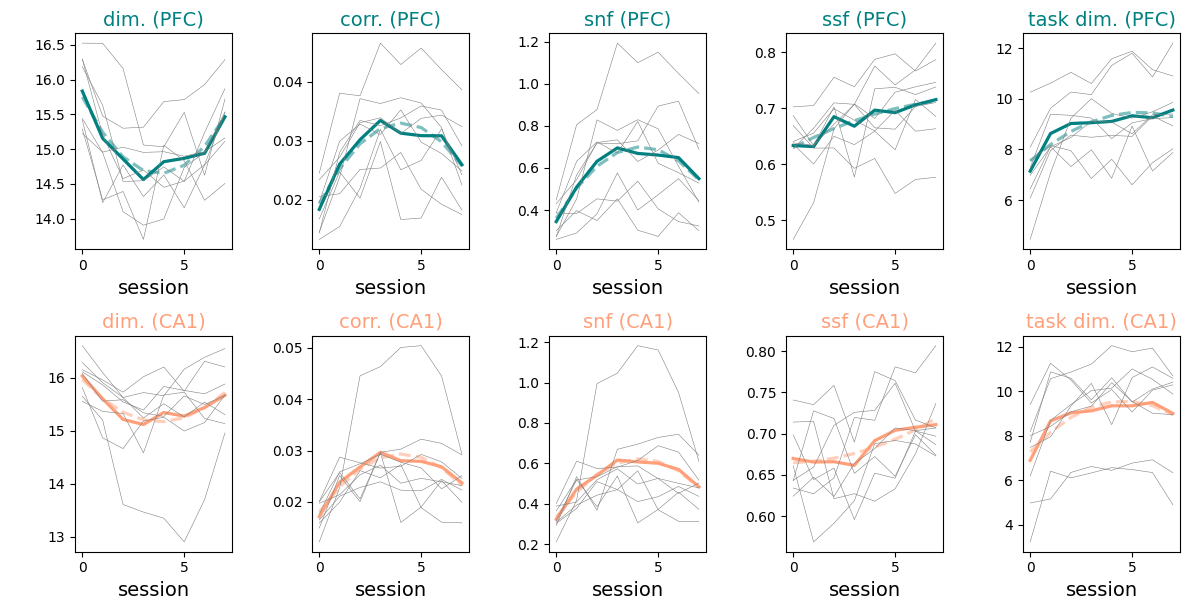

In [11]:
fsize=(12,6.2)
fn=14
lw=2.3
fig,ax=plt.subplots(2,5,figsize=fsize)
cs=['teal', 'lightsalmon']
for i in range(2): 
    for j in range(5):

        if j < 4: 
            lab_g = labs_g[j]  
            fit = fits[labs[i]][lab_g]
            g = Gs[i].mean(0)[...,j]
        else : 
            lab_g = 'task dim.'
            fit = fits[labs[i]]['task_dim']
            g = dims[i][...,1]
        
        ax[i,j].plot(T, fit, lw=lw, c=cs[i],ls='--',label='quad. model', alpha=0.5)
        ax[i,j].plot(np.arange(8), 
                     g.mean(0), lw=lw, c=cs[i], label='mean (data)')
        for k in range(8): 
            ax[i,j].plot(np.arange(8),
                         g[k],
                         c='grey',lw=0.4)
        ax[i,j].set_title(lab_g + f" ({labs[i]})",fontsize=fn, color=cs[i])
        ax[i,j].set_xlabel("session",fontsize=fn)
        ax[i,j].set_ylabel(" ",fontsize=fn)
        # ax[i,j].legend(fontsize=fn*2/3)
plt.tight_layout() 
fig.savefig(figdir + "/sm-rat_quad.pdf", bbox_inches='tight',dpi=300,transparent=True)

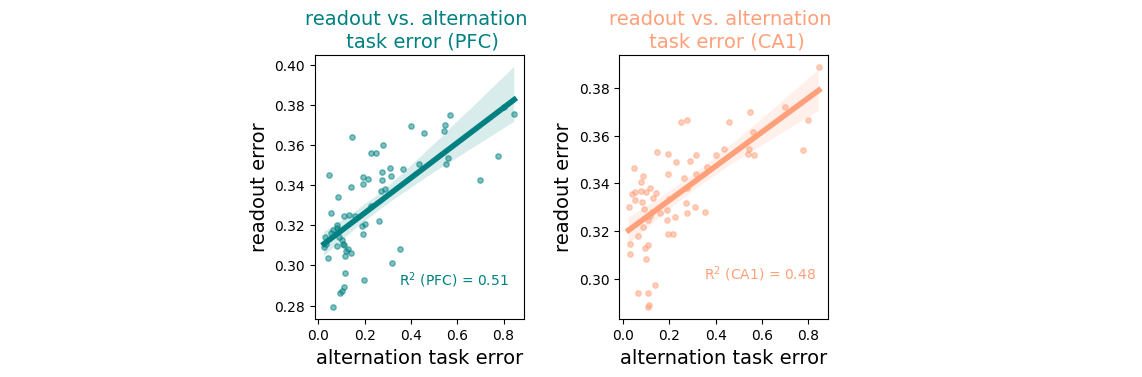

In [12]:
def make_err_plots(errs_pfc, all_geoms_pfc,
                     errs_ca1, all_geoms_ca1,
                     col_pfc, col_ca1,
                     S=8, lw=1, lwm=4, fn=14, ms=15, msm=20,
                     alpha=0.5, nrat=8):
    fsize=(12,7.75/2)
    fn=14
    fig,ax=plt.subplots(1,4,figsize=fsize)
    for i, (errs, all_geoms, col, label) in enumerate(zip(
        [errs_ca1, errs_pfc], [all_geoms_ca1, all_geoms_pfc],
        [col_ca1, col_pfc], ['CA1', 'PFC'])):
        sns.regplot(x=1-errs.mean(0)[:,:S,0].flatten(), # behv. 
                    y=errs.mean(0)[:,:S,2].flatten(), # the.
                    color=col,
                    scatter=True,
                    scatter_kws={'s' : ms, 'alpha' : 0.5},
                    line_kws={'lw':lwm, 'ls' : '-'},
                   ax=ax[2-i])
        r2 = pearsonr(1-errs.mean(0)[:,:S,0].flatten(),
                            errs.mean(0)[:,:S,2].flatten())[0]**2
        ax[2-i].text(0.35,0.3 if label == 'CA1' else 0.29, 
                     f'R$^2$ ({label}) = ' + str(round(r2,2)),
                    color = col)  
        ax[2-i].set_title(f"readout vs. alternation \n task error ({label})", fontsize=fn, color=col)
        ax[2-i].set_xlabel("alternation task error", fontsize=fn) 
        ax[2-i].set_ylabel("readout error", fontsize=fn)
    
    plt.tight_layout()
    ax[0].axis('off')
    ax[3].axis('off')
    return fig 
fig=make_err_plots(errs_pfc,all_geoms_pfc,errs_ca1,all_geoms_ca1,'teal','lightsalmon')
fig.savefig(figdir+"/sm_rat_bottom.pdf", dpi=300,  bbox_inches='tight',transparent=True)

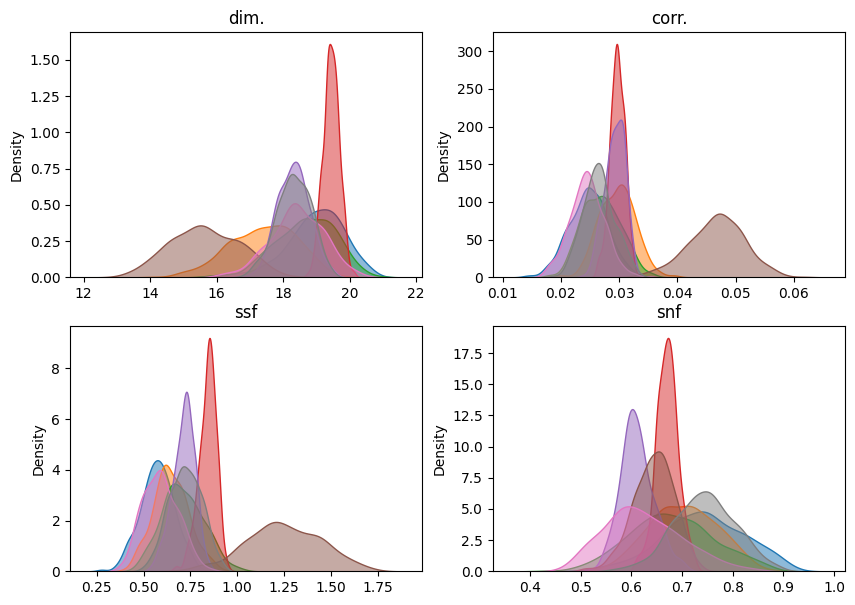

In [15]:
fig, axs = plt.subplots(2,2,figsize=(10,7))
sesh=3
names = ['dim.', 'corr.', 'ssf', 'snf']
for i, ax in enumerate(axs.flat):
    for j in range(8):
        # ax.hist(all_geoms_ca1[:,j,sesh,i], density=True, alpha=0.5)
        sns.kdeplot(all_geoms_ca1[:,j,sesh,i],
        ax=ax,fill=True, alpha=0.5)
        ax.set_title(names[i])

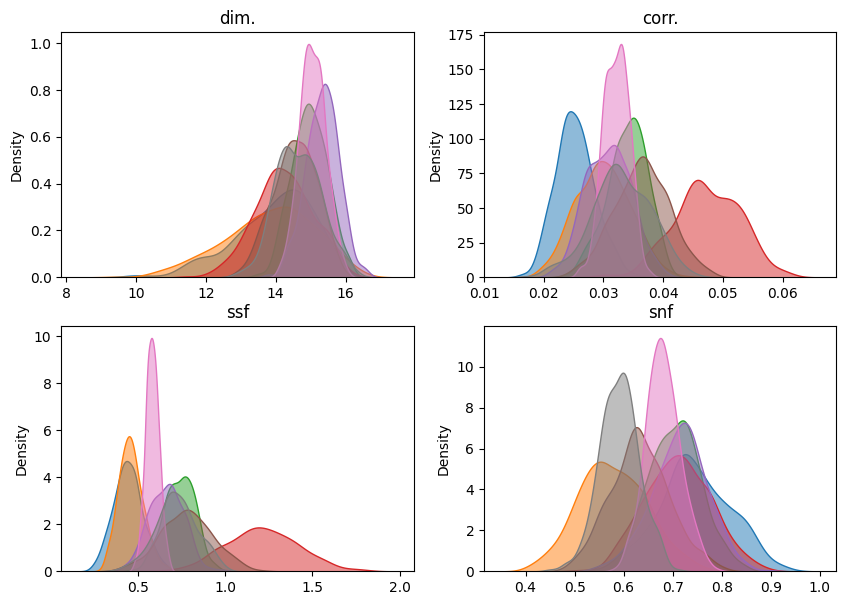

In [16]:
fig, axs = plt.subplots(2,2,figsize=(10,7))
sesh=3
names = ['dim.', 'corr.', 'ssf', 'snf']
for i, ax in enumerate(axs.flat):
    for j in range(8):
        # ax.hist(all_geoms_ca1[:,j,sesh,i], density=True, alpha=0.5)
        sns.kdeplot(all_geoms_pfc[:,j,sesh,i],
        ax=ax,fill=True, alpha=0.5)
        ax.set_title(names[i])